# Analysis of angular velocity

The rate of change of angular velocity is the angular acceleration
$\frac{d\omega(t)}{dt} = \alpha(t)$

By integrating we get
$\omega(t) = \int_0^t \alpha(t')dt'$

However, when the angular velocity is kept constant (the robot goes circles), the angular velocity measurements seem to decay exponentially. 

We could model the angular velocity measurements like this:
$\omega_\mathrm{meas}(t) = \int_0^t e^{-k(t-t')}\alpha(t')dt' = \sum_{i}  \Delta t\, e^{-k(t-t_i)}\alpha(t_i)$

The corresponding differential equation is
$\frac{d\omega_\mathrm{meas}(t)}{dt} = \alpha(t) - k\omega_\mathrm{meas}(t)$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget

In [2]:
#filename='/Users/viivihalla-aho/Documents/lego/legorobot/scripts/mvp_log_2022-05-01T14:13:36.log'
# Data with accumulated time and optimized code
#filename='C:\\Users\\antti\\legorobot\\scripts\\mvp_log_2022-05-07T16-20-44.log'
# One minute without stops
#filename='C:\\Users\\antti\\legorobot\\scripts\\mvp_log_2022-05-08T16-57-51.log'
# HUB not tilted
#filename='C:\\Users\\antti\\legorobot\\scripts\\mvp_log_2022-05-14T15-23-19.log'
# Less rough surface
reference = 'C:\\Users\\antti\\legorobot\\scripts\\mvp_log_2022-05-14T15-29-10.log'
# Rotation experiment
test_file = 'C:\\Users\\antti\\legorobot\\scripts\\mvp_log_2022-05-14T15-55-28.log'

In [3]:
def read_log_file(filename):
    acceleration = []
    angular_velocity = []
    timer= []
    distances = []

    def readmatrixline(file):
        return float(file.readline().strip().lstrip('[').rstrip('],').strip()) 

    with open(filename,'r') as file:
        line = file.readline()
        while line:
            if 'acceleration' in line.strip():
                acceleration.append([readmatrixline(file) for _ in range(3)])
            elif 'angular_velocity' in line.strip():
                angular_velocity.append([readmatrixline(file) for _ in range(3)])
            elif 'time' in line.strip():
                timer.append(float(line.strip().split(' ')[1]))
            elif 'distance' in line.strip():
                distances.append(float(line.strip().split(' ')[1]))
            line = file.readline()

    acceleration_a= np.array(acceleration)
    distances_a = np.array(distances)
    angular_velocity_a = np.array(angular_velocity)
    timer_a = np.array(timer)


    d_dict=dict(
        accelerationx=acceleration_a[:,0],
        accelerationy=acceleration_a[:,1],
        accelerationz=acceleration_a[:,2],
        distance=distances_a,
        angular_velocity_x=angular_velocity_a[:,0],
        angular_velocity_y=angular_velocity_a[:,1],
        angular_velocity_z=angular_velocity_a[:,2],
    )

    robot_df = pd.DataFrame(d_dict,index=pd.TimedeltaIndex(timer_a,unit='ms'))

    return robot_df

In [4]:
df_reference = read_log_file(reference)
df_test = read_log_file(test_file)

In [5]:
print(len(df_reference))
print(len(df_test))

593
591


## Determine exponential decay

<AxesSubplot:>

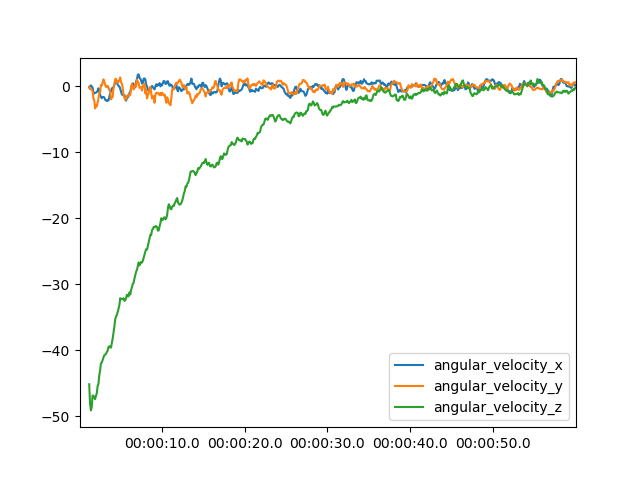

In [6]:
df_reference.filter(regex='angular_velocity').rolling(12).mean().plot()

In [11]:
from scipy.optimize import curve_fit

def exp_model(x, a, b, c):
    return a*np.exp(b*x) + c

popt, pcov = curve_fit(exp_model, df_reference.index.values[2:].astype(float), df_reference['angular_velocity_z'].values[2:], p0=[-5, -1e-10, 0], maxfev=10000)

In [12]:
popt

array([-5.30710409e+01, -1.00361027e-10, -1.23545085e-01])

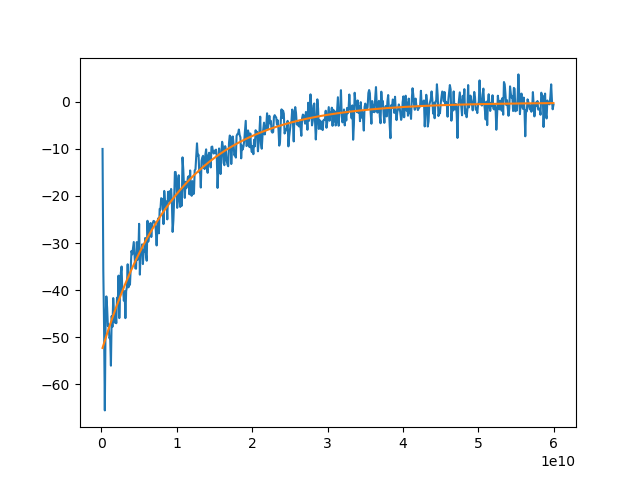

In [13]:
plt.figure()
plt.plot(df_reference['angular_velocity_z'])
plt.plot(df_reference.index, exp_model(df_reference.index.values.astype(float), *popt))

## Construct exponential decay model

In [14]:
N = df_test.shape[0]
C = np.zeros((N, N))
t = df_test.index.values.astype(float)
for nn in range(N):
    C[nn, :(nn+1)] = exp_model(t[nn] - t[:(nn+1)], 1, popt[1], 0)

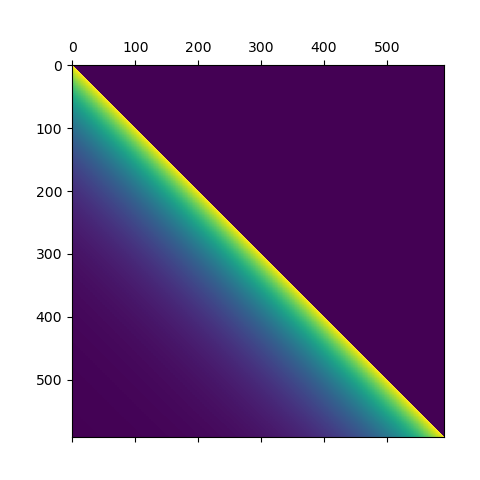

In [15]:
plt.matshow(C)

In [16]:
angular_acc = np.linalg.solve(C, df_test['angular_velocity_z'].values)

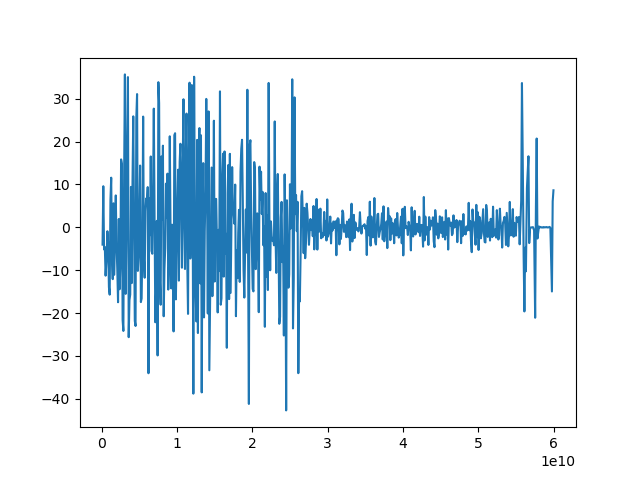

In [19]:
plt.figure()
plt.plot(df_test.index, angular_acc)

<AxesSubplot:>

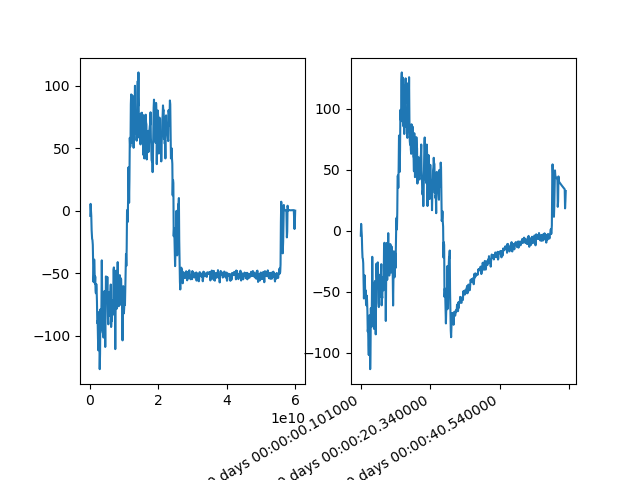

In [24]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(df_test.index, angular_acc.cumsum())
plt.sca(axs[1])
df_test['angular_velocity_z'].plot()

<AxesSubplot:>

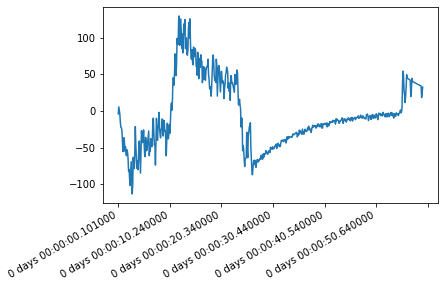

In [42]:
df_test['angular_velocity_z'].plot()
